In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('../data/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)


{'ban': 0, 'be': 1, 'beer': 2, 'bottle': 3, 'dish': 4, 'glass': 5, 'me': 6, 'soju': 7, 'trash': 8, 'vita': 9, 'wine': 10}


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    VGG16_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
    VGG16_model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
!nvidia-smi

Tue Dec  8 17:49:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |   7232MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#이미지 불러오기
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = '../data/image/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 50,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 10,
        class_mode="sparse"
    )

Found 192 images belonging to 11 classes.
Found 41 images belonging to 11 classes.


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import matplotlib.pyplot as plt


rootPath = '../data/image/'


## Pretrained Network
with tf.device('/device:GPU:0'):
    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    model_base.trainable = False  # Convolution Layer 완전 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(7*7*512,)))
    model.add(Dense(256,
                    activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(11,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=2e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(trainGen,
                        steps_per_epoch=2,
                        epochs=250,
                        validation_data=validationGen,
                        validation_steps=2,
                        verbose=2)

    ### 여기까지가 아래의 작업 처리입니다.

    # Pretrained Network 위에 새로운 Network을 추가합니다.
    # Base Network을 동결합니다.
    # 새로 추가한 Network을 학습합니다.


    ### 아래의 작업이 추가로 필요합니다.
    # Base Network에서 일부 Layer의 동결을 해제합니다.
    # 동결을 해제한 층과 새로 추가한 층을 함께 학습합니다.
    fine_tune_at = 10

    model_base.trainable = True

    for layer in model_base.layers[-fine_tune_at:]:
        layer.trainable =  False

    ## learning rate를 줄이는게 일반적(미세조절)        
    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    ## 재학습 진행
    history = model.fit(trainGen,
                        steps_per_epoch=2,
                        epochs=100,
                        validation_data=validationGen,
                        validation_steps=2,
                        verbose=1)
    model.save('../model/recycle_vgg16_fine_1208.h5')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2827      
Total params: 21,141,323
Trainable params: 6,426,123
Non-trainable params: 14,715,200
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 2 steps
Epoch 1/25

Epoch 53/250
2/2 - 2s - loss: 0.1802 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.5483 - val_sparse_categorical_accuracy: 0.9000
Epoch 54/250
2/2 - 2s - loss: 0.1823 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.5791 - val_sparse_categorical_accuracy: 0.8000
Epoch 55/250
2/2 - 2s - loss: 0.1644 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.5185 - val_sparse_categorical_accuracy: 0.9000
Epoch 56/250
2/2 - 2s - loss: 0.1666 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.9000
Epoch 57/250
2/2 - 2s - loss: 0.1861 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.5879 - val_sparse_categorical_accuracy: 0.9000
Epoch 58/250
2/2 - 2s - loss: 0.2068 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.5927 - val_sparse_categorical_accuracy: 0.8500
Epoch 59/250
2/2 - 2s - loss: 0.2299 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.5529 - val_sparse_categorical_accuracy: 0.9000
Epoch 60/250
2/2 - 2s - loss: 0.1008 - sparse_ca

Epoch 114/250
2/2 - 2s - loss: 0.0831 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.9744 - val_sparse_categorical_accuracy: 0.6000
Epoch 115/250
2/2 - 2s - loss: 0.1054 - sparse_categorical_accuracy: 0.9783 - val_loss: 1.0093 - val_sparse_categorical_accuracy: 0.6500
Epoch 116/250
2/2 - 2s - loss: 0.1111 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.7500
Epoch 117/250
2/2 - 2s - loss: 0.0604 - sparse_categorical_accuracy: 0.9891 - val_loss: 1.2234 - val_sparse_categorical_accuracy: 0.5500
Epoch 118/250
2/2 - 2s - loss: 0.0531 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9509 - val_sparse_categorical_accuracy: 0.6000
Epoch 119/250
2/2 - 2s - loss: 0.1142 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.1958 - val_sparse_categorical_accuracy: 0.9500
Epoch 120/250
2/2 - 2s - loss: 0.0860 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9500
Epoch 121/250
2/2 - 2s - loss: 0.0834 - s

Epoch 174/250
2/2 - 2s - loss: 0.1044 - sparse_categorical_accuracy: 0.9783 - val_loss: 1.5879 - val_sparse_categorical_accuracy: 0.6000
Epoch 175/250
2/2 - 2s - loss: 0.0396 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.1833 - val_sparse_categorical_accuracy: 0.6500
Epoch 176/250
2/2 - 2s - loss: 0.0515 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.7000
Epoch 177/250
2/2 - 2s - loss: 0.0336 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.5346 - val_sparse_categorical_accuracy: 0.7500
Epoch 178/250
2/2 - 2s - loss: 0.0775 - sparse_categorical_accuracy: 0.9783 - val_loss: 1.5131 - val_sparse_categorical_accuracy: 0.5500
Epoch 179/250
2/2 - 2s - loss: 0.0363 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.7000
Epoch 180/250
2/2 - 2s - loss: 0.1556 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.0706 - val_sparse_categorical_accuracy: 1.0000
Epoch 181/250
2/2 - 2s - loss: 0.0314 - s

Epoch 234/250
2/2 - 2s - loss: 0.0313 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 0.9500
Epoch 235/250
2/2 - 2s - loss: 0.0533 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0968 - val_sparse_categorical_accuracy: 0.9500
Epoch 236/250
2/2 - 2s - loss: 0.0375 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 1.0000
Epoch 237/250
2/2 - 2s - loss: 0.0808 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.2886 - val_sparse_categorical_accuracy: 0.8500
Epoch 238/250
2/2 - 2s - loss: 0.0605 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.2474 - val_sparse_categorical_accuracy: 0.8500
Epoch 239/250
2/2 - 2s - loss: 0.0205 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.6500
Epoch 240/250
2/2 - 2s - loss: 0.0126 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7000
Epoch 241/250
2/2 - 2s - loss: 0.0140 - s

2/2 [==============================] - 2s 1s/step - loss: 0.0080 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0119 - val_sparse_categorical_accuracy: 1.0000
Epoch 34/100
2/2 [==============================] - 3s 1s/step - loss: 0.0130 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 1.0000
Epoch 35/100
2/2 [==============================] - 3s 1s/step - loss: 0.0066 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0084 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/100
2/2 [==============================] - 3s 1s/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0085 - val_sparse_categorical_accuracy: 1.0000
Epoch 37/100
2/2 [==============================] - 3s 1s/step - loss: 0.0081 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0098 - val_sparse_categorical_accuracy: 1.0000
Epoch 38/100
2/2 [==============================] - 3s 1s/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9900 - val_loss: 

2/2 [==============================] - 2s 1s/step - loss: 0.0133 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0088 - val_sparse_categorical_accuracy: 1.0000
Epoch 80/100
2/2 [==============================] - 2s 1s/step - loss: 0.0115 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0259 - val_sparse_categorical_accuracy: 1.0000
Epoch 81/100
2/2 [==============================] - 3s 1s/step - loss: 0.0071 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1488 - val_sparse_categorical_accuracy: 0.9500
Epoch 82/100
2/2 [==============================] - 3s 1s/step - loss: 0.0046 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1100 - val_sparse_categorical_accuracy: 0.9500
Epoch 83/100
2/2 [==============================] - 3s 1s/step - loss: 0.0080 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9500
Epoch 84/100
2/2 [==============================] - 2s 1s/step - loss: 0.0065 - sparse_categorical_accuracy: 1.0000 - val_loss: 

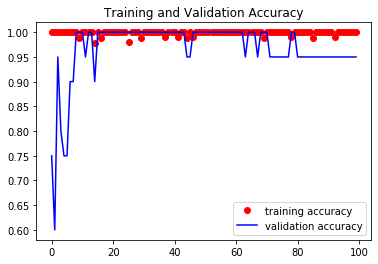

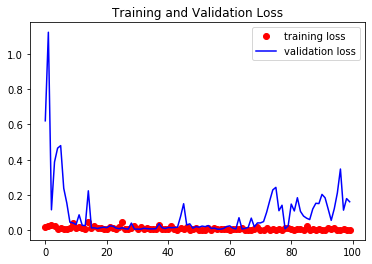

In [8]:
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


[ 9.  8.  8.  8. 10.  8.  8.  5. 10.  8.]
[1.8175604e-04 2.6274030e-04 3.5733236e-05 3.5134450e-02 6.1637722e-05
 4.1573450e-05 3.0414165e-05 5.2986521e-04 9.6326870e-01 2.8688186e-05
 4.2439980e-04]
Confusion Matrix
[ 9  3  8  3 10  8  8  5 10  8]


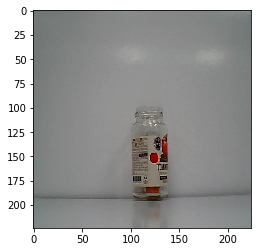

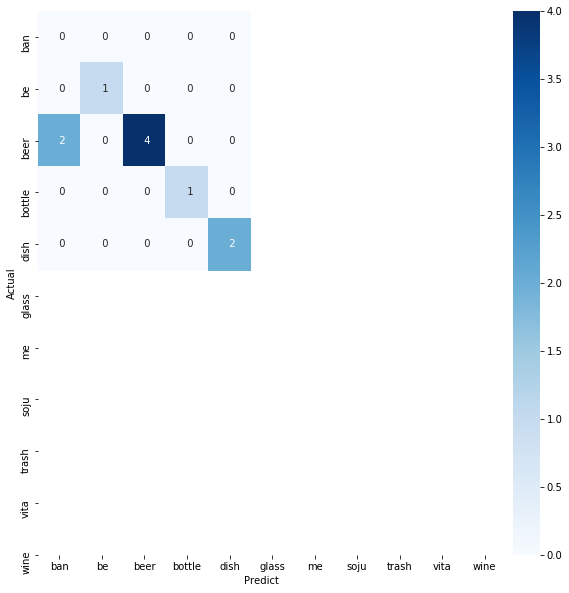

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


    model_path = '../model/recycle_vgg16_fine_1208.h5'


    vgg_model = tf.keras.models.load_model(model_path)


    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[6])

    #Confution Matrix and Classification Report
    Y_pred = vgg_model.predict_generator(validationGen, 1)
    
    print(Y_pred[6])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()